In [1]:
# General libraries
import numpy as np
from scipy import stats
import os

# Parallelisation libraries
from joblib import Parallel, delayed

# Module functions
# import ximinf.selection_effects as se
import ximinf.generate_sim as gsim
import ximinf.nn_inference as nninf
import ximinf.nn_test as nnte
import ximinf.nn_train as nntr

# Plot libraries
import matplotlib.pyplot as plt
import corner

from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
num_threads = os.cpu_count()
print(f"Number of threads: {num_threads}")

Number of threads: 48


## Load NN

In [3]:
# Parameters
models_per_group, models_config = nninf.load_autoregressive_nn('../data/NNs/nn_model_priors_M1000_cosmo_err_z_small_sample') #nn_model_priors_M1000_cosmo_err_z_smaller_dropout

for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

## Generate test samples

In [4]:
# -------- User parameters --------

N = 1 # Number of samples 100_000
M = 1000 # Number of SNe per sample #3_000

# ---------------------------------

params = {
    'mabs': -19.3,
    'alpha_low': -0.271,
    'alpha_high': -0.083,
    'beta': 3.31,
    'gamma': 0.175,
    'sigma_int': 0.15,
    'Om0': 0.3,
}

columns = models_config["shared"]["columns"]

n_realisation = 200

N_total = N*n_realisation

# print("Running parallel simulations...")

# results = Parallel(n_jobs=max(1,min(N_total//20, num_threads-2)))(
#     delayed(gsim.simulate_one)(
#         params,
#         z_max=0.06,
#         M=M,
#         cols=columns,
#         N=N_total,
#         i=i
#     )
#     for i in range(N_total)
# )


# print("... done")

In [5]:
# LEMAITRE simulation
M_low_z = 1000
M_high_z = 1000
M = M_low_z + M_high_z

In [6]:
# Define errors
def x1_err(z, z0, a, b, loc, scale):
    return stats.beta.rvs(a, b, loc, scale)*np.maximum(z/z0, 0.3)

def c_err(z, z0, a, loc, scale):
    return stats.alpha.rvs(a, loc, scale)*np.maximum(z/z0, 0.3)

def magobs_err(z, z0, a, b, loc, scale):
    return stats.beta.rvs(a, b, loc, scale)*np.maximum(z/z0, 0.3)

def mass_err(z, z0, a, loc, scale):
    return stats.alpha.rvs(a, loc, scale)*np.maximum(z/z0, 0.3)

def localcolor_err(z, z0, a, loc, scale):
    return stats.alpha.rvs(a, loc, scale)*np.maximum(z/z0, 0.3)

noise_model = {
    # SALT paramerers
    "x1": { "func": x1_err,
            "kwargs": {"z": "@z", "z0":0.1, "a":1.78, "b":793.7, "loc":0.03, "scale":66.4}
          }, 
    "c": { "func": c_err,
            "kwargs": {"z": "@z", "z0":0.1,"a":3.27e+00, "loc":1.71e-02, "scale":5.03e-02}
          },

    # derived

    "magobs": { "func": magobs_err,
            "kwargs": {"z": "@z", "z0":0.1, "a":3., "b":600., "loc":0.03 , "scale":2.}
            },
    
    # Environments
    "mass": { "func": mass_err,
            "kwargs": {"z": "@z", "z0":0.1, "a":3.58e+00, "loc":1.01e-01, "scale":1.55e-03}
            },
    
    "localcolor": { "func": localcolor_err,
            "kwargs":{"z": "@z", "z0":0.1, "a":2, "loc": 0.005, "scale": 0.05}
            }
    }


In [8]:
noise_model_low = {
    k: {**v, "kwargs": v["kwargs"].copy()}
    for k, v in noise_model.items()
}

z0_low = 0.03
for dict_key in noise_model_low:
    noise_model_low[dict_key]["kwargs"]["z0"] = z0_low
    
noise_model_high = {
    k: {**v, "kwargs": v["kwargs"].copy()}
    for k, v in noise_model.items()
}

z0_high = 0.3
for dict_key in noise_model_high:
    noise_model_high[dict_key]["kwargs"]["z0"] = z0_high

print("Running parallel simulations at low redshift...")
# with parallel_backend("threading"):
results_low_z = Parallel(n_jobs=min(N_total//20, num_threads-2))(
    delayed(gsim.simulate_one)(
        params,
        z_max=0.06,
        M=M_low_z,
        cols=columns,
        errormodel=noise_model_low,
        N=N_total,
        i=i
    )
    for i in range(N_total)
)
print("... done")

print("Running parallel simulations at high redshift...")
# with parallel_backend("threading"):
results_high_z = Parallel(n_jobs=min(N_total//20, num_threads-2))(
    delayed(gsim.simulate_one)(
        params,
        z_max=1,
        M=M_high_z,
        cols=columns,
        errormodel=noise_model_high,
        N=N_total,
        i=i
    )
    for i in range(N_total)
)
print("... done")


Running parallel simulations at low redshift...
... doneon 200/200
Running parallel simulations at high redshift...
... doneon 200/200


In [9]:
results = []

for low, high in zip(results_low_z, results_high_z):
    combined = {
        col: low[col] + high[col]
        for col in columns
    }
    results.append(combined)


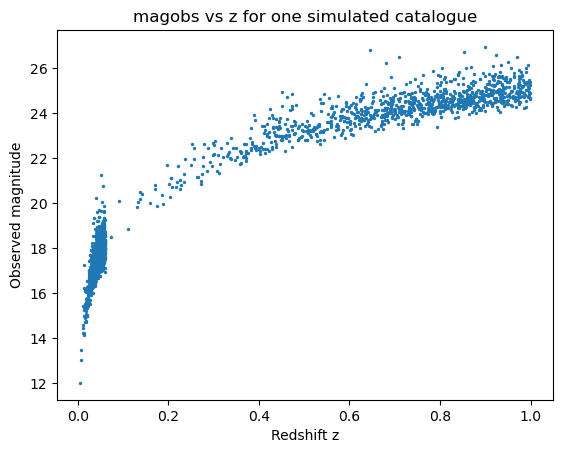

Number of SNe after selection: 2000


In [10]:
# Take one simulation
example = results[6]

# Convert columns to NumPy arrays for easier indexing
magobs = np.array(example['magobs'])
z      = np.array(example['z'])

# Apply selection (magobs > 0)
mask = magobs > 0
magobs_cut = magobs[mask]
z_cut = z[mask]

# Plot
plt.figure()
plt.scatter(z_cut, magobs_cut, s=2)
plt.xlabel("Redshift z")
plt.ylabel("Observed magnitude")
plt.title("magobs vs z for one simulated catalogue")
plt.show()

# Number of SNe after selection
print('Number of SNe after selection:', len(magobs_cut))


In [11]:
# Jax libraries
import jax
import jax.numpy as jnp

In [12]:
# Try GPU backends in priority order
gpu = None
for backend in ("METAL", "cuda", "gpu"):
    try:
        devs = jax.devices(backend)
    except RuntimeError:
        continue
    if devs:
        gpu = devs[0]
        break

# Fallback
cpu = jax.devices("cpu")[0]

# Use GPU if found
if gpu=='cuda':
    nntr.print_gpu_memory()
    device = gpu 
elif gpu is not None:
    device = gpu
else:
    device = cpu
    
jax.default_device(device)
    
backend = jax.default_backend()
print(backend)

gpu


In [13]:
key = jax.random.PRNGKey(42)

## Pre-process samples

In [14]:
data_dict = {col: np.zeros((N_total, M), dtype=np.float32) for col in columns}

for i, sim_data in enumerate(results):  # sim_data is just the dict returned by simulate_one
    for col, arr in sim_data.items():   # arr is a list of length M
        data_dict[col][i, :] = arr   # fill row i

In [15]:
z = data_dict['z']
magobs = data_dict["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

In [16]:
# Take care to not run the correction twice
mu_planck18, magobs_corr = nntr.rm_cosmo(z, magobs)
jax.config.update("jax_enable_x64", False)

data_dict['magobs'] = magobs_corr

In [17]:
# Make a copy to avoid in-place modification
columns = models_config['shared']['columns']
data_norm = {k: data_dict[k].copy() for k in columns}

data_stats = models_config['shared']['data_stats']

for col, arr in data_norm.items():
    mu = data_stats[col]['mu']
    sigma = data_stats[col]['sigma']

    if col == 'magobs':
        # mask zeros
        mag_mask = arr != 0.0
        data_norm[col] = arr.at[mag_mask].set((arr[mag_mask] - mu) / sigma)
    else:
        data_norm[col] = (arr - mu) / sigma

In [18]:
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

global_param_names = models_config['shared']['global_param_names']
print(f"Parameters : {global_param_names}")

param_groups = models_config['shared']['param_groups']

Parameters : ['mabs', 'alpha_low', 'alpha_high', 'beta', 'gamma', 'sigma_int', 'Om0']


In [19]:
# # ========== Set priors ==========
# ranges = {
#     'mabs': (-21, -18), #(-19.5, -19.0),
#     'alpha_low': (-0.5,0), #(-0.5, -0.0),
#     'alpha_high': (-0.3,0.2), #(-0.5, -0.0),
#     'beta': (2.5,4), #(2.0, 4.0),
#     'gamma': (-0.1,0.4), #(0.0, 0.3)
#     'sigma_int': (0.0, 0.3),
#     'Om0': (0.0, 0.6),
# }

# types = {
#     'mabs': 'gaussian',         # Uniform in [-21, -18]
#     'alpha_low': 'gaussian',
#     'alpha_high': 'gaussian',
#     'beta': 'gaussian',
#     'gamma': 'gaussian',
#     'sigma_int': 'half-gaussian',  # Positive, includes zero
#     'Om0': 'positive-gaussian',
# }

# priors = {name: {'range': np.array(ranges[name], dtype=np.float32), 'type': types[name]}
#           for name in ranges.keys()}


In [20]:
priors = models_config['shared']['priors']

# Change the priors here if needed

# Example
priors['alpha_low']['range'] = jnp.array([-0.4, -0.1])
priors['alpha_high']['range'] = jnp.array([-0.2, 0.0])
priors['gamma']['range'] = jnp.array([0.05, 0.2])
priors['Om0']['range'] = jnp.array([0.2, 0.4])
priors['sigma_int']['range'] = jnp.array([0.1, 0.2])

# if 'mabs' in priors:
#     priors['mabs']['range'] += 19.3

In [21]:
param_stats = models_config['shared']['param_stats']

normalized_priors = {}

for name, prior in priors.items():
    mu = param_stats[name]['mu']
    sigma = param_stats[name]['sigma']

    norm_range = (prior['range'] - mu) / sigma
        
    normalized_priors[name] = {
        'range': norm_range,
        'type': prior['type']  # type stays unchanged
    }


theta_init_dict = {
    name: 0.5 * (priors[name]['range'][0] + 
                 priors[name]['range'][1])
    for name in global_param_names
}

theta_init_dict['mabs'] = 0.0
theta_init_dict['gamma'] = 0.17
theta_init_dict['alpha_low'] = -0.28
theta_init_dict['alpha_high'] = -0.08
theta_init_dict['sigma_int'] = 0.15
theta_init_dict['Om0'] = 0.3

theta_init_normed_dict = {
    name: (
        theta_init_dict[name] - param_stats[name]['mu']
    ) / param_stats[name]['sigma']
    for name in global_param_names
}

theta_init_normed = jnp.array(
    [theta_init_normed_dict[name] for name in global_param_names]
)

In [22]:
# Convert each column to a 1D array and concatenate into shape (M*C,)
# Prepare inference arrays
data_arrays = [data_norm[col] for col in columns]  # list of (M,)
n_cols = len(columns)

# Stack along last axis to get shape (M, n_cols)
data_stacked = jnp.stack(jnp.asarray(data_arrays), axis=-1)  

# Flatten and add batch dimension: (1, M * n_cols)
data_concat_infer = data_stacked.reshape(N_total, M * n_cols)

# Concatenate features + mask
inputs_infer = jnp.concatenate([data_concat_infer, jnp.asarray(mask).reshape(N_total,M)], axis=-1)

print(inputs_infer.shape)

(200, 20000)


In [23]:
priors

{'Om0': {'range': Array([0.2, 0.4], dtype=float64),
  'type': 'positive-gaussian'},
 'alpha_high': {'range': Array([-0.2,  0. ], dtype=float64),
  'type': 'gaussian'},
 'alpha_low': {'range': Array([-0.4, -0.1], dtype=float64),
  'type': 'gaussian'},
 'beta': {'range': Array([2.5, 4. ], dtype=float32), 'type': 'gaussian'},
 'gamma': {'range': Array([0.05, 0.2 ], dtype=float64), 'type': 'gaussian'},
 'mabs': {'range': Array([-1.7000008,  1.2999992], dtype=float32),
  'type': 'gaussian'},
 'sigma_int': {'range': Array([0.1, 0.2], dtype=float64),
  'type': 'positive-gaussian'}}

## Make inference

In [24]:
# ========== MCMC Sampling ==========

# ----------------------------
# Precompute parameter indices
# ----------------------------

group_names_list = []
for g in param_groups:
    if isinstance(g, str):
        group_names_list.append([g])  # wrap single parameter in a list
    else:
        group_names_list.append(g)  
        
visible_indices, group_indices = nnte.preprocess_groups(param_groups, global_param_names)

n_pull = 10 #min(200, N_total)

n_points = 100
post_pull = jnp.zeros((n_pull, n_points, len(global_param_names)))

print("Launch MCMCs ...")
for i in range(n_pull):
    print(f'Sample {i+1}/{n_pull}', end='\r')

    def log_post(theta):
        # Use the new grouped log-prob function
        return nnte.log_prob_fn_groups(
            theta,
            models_per_group,  # list of models per group
            inputs_infer[i,:],
            normalized_priors,
            visible_indices,
            group_indices,
            group_names_list
        )
    
    # Run MCMC
    
    key, samples = nnte.sample_posterior(
        log_post,
        n_warmup=1000,
        n_samples=n_points,
        init_position=theta_init_normed,
        rng_key=key
    )

    post_pull = post_pull.at[i, :, :].set(samples)
    
print("...finished")

Launch MCMCs ...


TypeError: cond branches must have equal output types but they differ.

true_fun is <lambda> at /pbs/throng/ztf/anaconda3/envs/sbi/lib/python3.11/site-packages/blackjax/mcmc/proposal.py:131
false_fun is <lambda> at /pbs/throng/ztf/anaconda3/envs/sbi/lib/python3.11/site-packages/blackjax/mcmc/proposal.py:137

  * the output of true_fun at path .state.position has type float64[7] but the corresponding output of false_fun has type float32[7], so the dtypes do not match;
  * the output of true_fun at path .state.logdensity has type float64[] but the corresponding output of false_fun has type float32[], so the dtypes do not match;
  * the output of true_fun at path .state.logdensity_grad has type float64[7] but the corresponding output of false_fun has type float32[7], so the dtypes do not match.

Revise true_fun and/or false_fun so that all output types match.

In [ ]:
index_corner = 6

truths = np.array([params[name] for name in global_param_names])
truths[0]+=19.3

post = post_pull[index_corner,:,:]

# post has shape (n_samples, n_params)
n_points, n_params = post.shape

# Convert post from array to dict with column names
post_dict = {name: post[:, i] for i, name in enumerate(global_param_names)}

# Unnormalize each parameter
post_unnormed_dict = nntr.unnormalize(post_dict, param_stats)

# Convert back to array for plotting
post_unnormed = jnp.stack([post_unnormed_dict[name] for name in global_param_names], axis=1)

# Now post_unnormed[:, i] contains the real-scale parameters
x = post_unnormed[:, 0]

ranges_from_priors = [
    (float(priors[name]['range'][0]), float(priors[name]['range'][1]))
    for name in global_param_names
]

print(ranges_from_priors)

In [ ]:
fig = corner.corner(
    np.array(post_unnormed),
    labels=global_param_names,
    range=ranges_from_priors,
    truths=truths,
    quantiles=[0.16, 0.5, 0.84],      # 1D marginal: 1σ
    levels=[0.393469, 0.864665],     # 2D contours: 1σ, 2σ
    show_titles=True,
    title_fmt=".4f",
    bins=40,
    smooth=1.0,
    color="#1F487E",
    truth_color="#A31621", 
    truth_alpha=0.8
)

plt.savefig("./corner.png",dpi=150)
plt.show()

In [171]:
post_pull_unnormed = []

for c in range(n_pull):
    post = post_pull[c]  # (n_samples, n_params)

    post_dict = {
        name: post[:, i]
        for i, name in enumerate(global_param_names)
    }

    post_unnormed_dict = nntr.unnormalize(post_dict, param_stats)

    post_unnormed = jnp.stack(
        [post_unnormed_dict[name] for name in global_param_names],
        axis=1
    )

    post_pull_unnormed.append(post_unnormed)

post_pull_unnormed = jnp.stack(post_pull_unnormed, axis=0)


In [ ]:
post_pull_mean = jnp.mean(post_pull_unnormed, axis=1)
post_pull_std = jnp.std(post_pull_unnormed, axis=1)
pull = (post_pull_mean - truths)/post_pull_std

In [173]:
post_pull_std

Array([[2.07027514e-02, 2.24754419e-02, 1.82126090e-02, 4.85390089e-02,
        2.24509574e-02, 1.54069951e-02, 9.26820934e-03],
       [2.18991619e-02, 2.58127432e-02, 1.93688627e-02, 6.02921695e-02,
        1.43651254e-02, 1.04168635e-02, 1.07546737e-02],
       [2.00750809e-02, 2.74447538e-02, 1.79149192e-02, 4.88787033e-02,
        2.27902681e-02, 1.16861807e-02, 1.16599668e-02],
       [2.25654785e-02, 2.25909986e-02, 1.17965387e-02, 4.40971255e-02,
        2.92765722e-02, 1.51921762e-02, 5.69678750e-03],
       [2.73725241e-02, 3.98290418e-02, 2.41272207e-02, 5.34717850e-02,
        1.90358311e-02, 1.39597356e-02, 9.93156619e-03],
       [1.79334041e-02, 2.59213969e-02, 1.58631131e-02, 3.36403772e-02,
        1.74323749e-02, 1.16805742e-02, 1.00814831e-02],
       [0.00000000e+00, 2.38418579e-07, 5.21540642e-08, 0.00000000e+00,
        4.47034836e-08, 1.49011612e-07, 2.98023224e-07],
       [1.57079939e-02, 3.80809307e-02, 2.83885207e-02, 7.13514835e-02,
        1.82518400e-02, 5

ValueError: supplied range of [0.29830726981163025, inf] is not finite

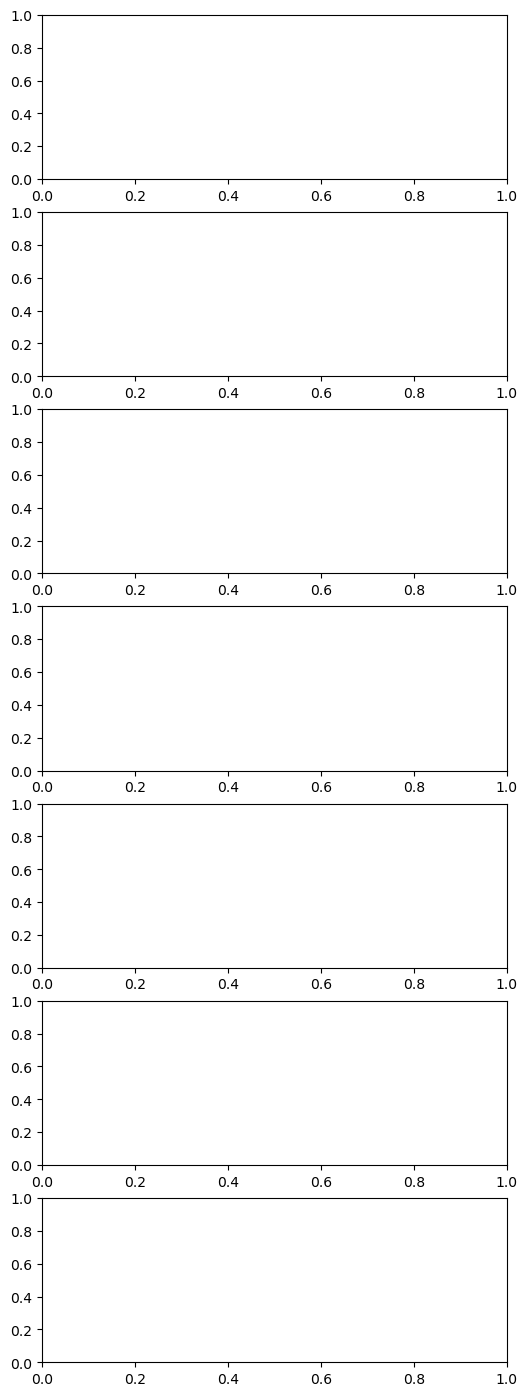

In [172]:
fig, axes = plt.subplots(
    n_params,
    1,
    figsize=(6, 2.5 * n_params),
    sharex=False,
)

# Make axes iterable even if n_params == 1
axes = np.atleast_1d(axes)

for i, ax in enumerate(axes):
    # Histogram of pulls
    ax.hist(
        pull[:, i],
        bins=20,
        density=True,
        color="#1F487E",
        alpha=0.8,
        label="Pulls",
    )

    # Standard normal curve
    x = np.linspace(-4, 4, 200)
    pdf = stats.norm.pdf(x, loc=0, scale=1)
    ax.plot(x, pdf, color="#A31621", linewidth=2, label="N(0,1)")

    ax.set_title(global_param_names[i])
    ax.legend()

plt.tight_layout()
plt.savefig('pull.png', dpi=150)
plt.show()


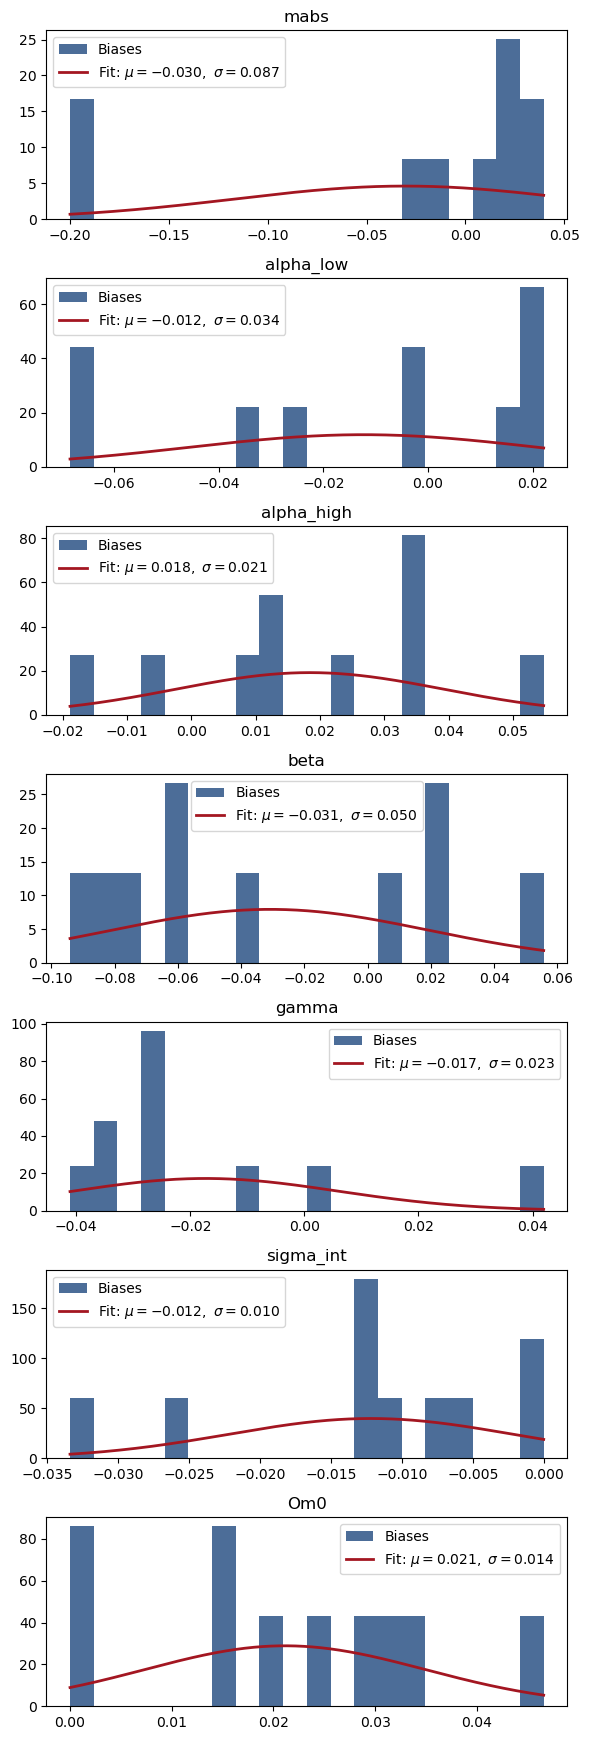

In [118]:
bias = (post_pull_mean - truths)

fig, axes = plt.subplots(
    n_params,
    1,
    figsize=(6, 2.5 * n_params),
    sharex=False,
)

# Make axes iterable even if n_params == 1
axes = np.atleast_1d(axes)

for i, ax in enumerate(axes):
    # Histogram of pulls
    ax.hist(
        bias[:, i],
        bins=20,
        density=True,
        color="#1F487E",
        alpha=0.8,
        label="Biases",
    )

    # Fit Gaussian to samples
    mu_hat, sigma_hat = stats.norm.fit(bias[:, i])

    # Plot fitted Gaussian
    x = np.linspace(bias[:, i].min(), bias[:, i].max(), 400)
    pdf_fit = stats.norm.pdf(x, loc=mu_hat, scale=sigma_hat)
    ax.plot(
        x,
        pdf_fit,
        color="#A31621",
        linewidth=2,
        label=fr"Fit: $\mu={mu_hat:.3f},\ \sigma={sigma_hat:.3f}$",
    )

    ax.set_title(global_param_names[i])
    ax.legend()

plt.tight_layout()
plt.savefig('bias.png', dpi=150)
plt.show()
